In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, balanced_accuracy_score
from sklearn.tree import DecisionTreeClassifier
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import shap

In [2]:
np.random.seed(42)
torch.manual_seed(42)
device = "cpu"

### Load Data

In [3]:
train_df = pd.read_csv('heart_failure/train_val_split.csv')
y = train_df.loc[:,'HeartDisease']
train_df = train_df.drop(columns=['HeartDisease'])

In [4]:
test_df = pd.read_csv('heart_failure/test_split.csv')
y_test = test_df.loc[:,'HeartDisease']
test_df = test_df.drop(columns=['HeartDisease'])

## Q1 Exploratory Data Analysis

### Columns

In [5]:
train_df.columns

Index(['Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol', 'FastingBS',
       'RestingECG', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ST_Slope'],
      dtype='object')

### Checking for Nans

In [6]:
train_df.isnull().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
dtype: int64

### One-hot encode categorical features

There are 5 feature columns with string values. <br>
These need to be converted to numerical values in order to use them. <br>
This done by one-hot encoding each of these features.

Sex: M,F <br>
ChestPainType: 'ATA', 'ASY', 'NAP', 'TA' <br>
RestingECG: 'Normal', 'ST', 'LVH' <br>
ExerciseAngina: 'N', 'Y' <br>
ST_Slope: 'Up', 'Flat', 'Down'

In [7]:
def one_hot(df):
    
    df = df.replace({'M': 0.0, 'F': 1.0, 'N': 0.0, 'Y': 1.0})

    ata = (df.loc[:,'ChestPainType'] == 'ATA').to_numpy().astype(float)
    asy = (df.loc[:,'ChestPainType'] == 'ASY').to_numpy().astype(float)
    nap = (df.loc[:,'ChestPainType'] == 'NAP').to_numpy().astype(float)
    ta = (df.loc[:,'ChestPainType'] == 'TA').to_numpy().astype(float)

    df['ATA'] = ata
    df['ASY'] = asy
    df['NAP'] = nap
    df['TA'] = ta
    df = df.drop(columns=['ChestPainType'])

    normal = (df.loc[:,'RestingECG'] == 'Normal').to_numpy().astype(float)
    st = (df.loc[:,'RestingECG'] == 'ST').to_numpy().astype(float)
    lvh = (df.loc[:,'RestingECG'] == 'LVH').to_numpy().astype(float)

    df['Normal'] = normal
    df['ST'] = st
    df['LVH'] = lvh
    df = df.drop(columns=['RestingECG'])

    up = (df.loc[:,'ST_Slope'] == 'Up').to_numpy().astype(float)
    flat = (df.loc[:,'ST_Slope'] == 'Flat').to_numpy().astype(float)
    down = (df.loc[:,'ST_Slope'] == 'Down').to_numpy().astype(float)

    df['Up'] = up
    df['Flat'] = flat
    df['Down'] = down
    df = df.drop(columns=['ST_Slope'])
    
    return df

In [8]:
train_df = one_hot(train_df)
test_df = one_hot(test_df)

In [9]:
train_df['HeartDisease'] = y

### Histograms

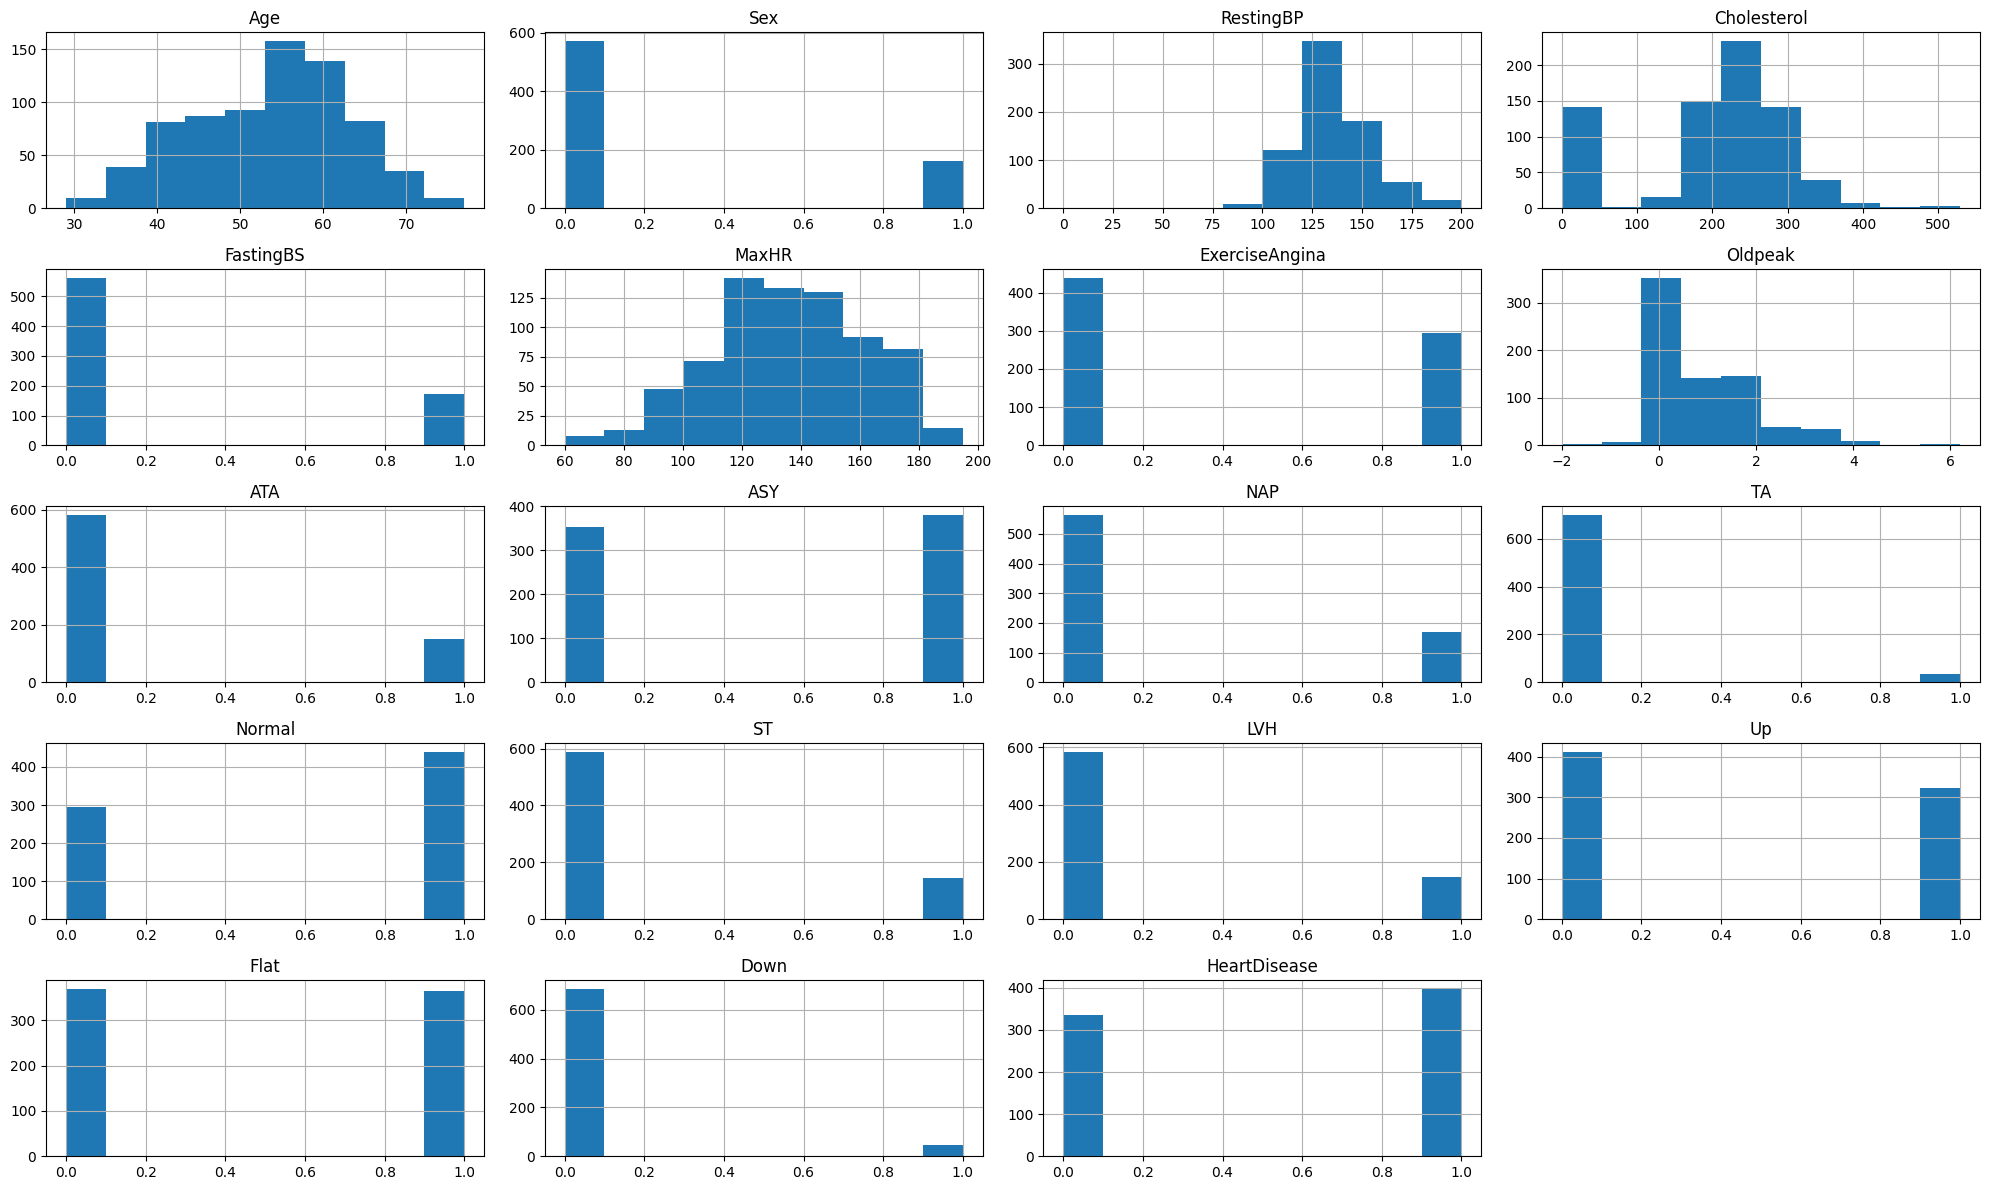

In [10]:
plt.rcParams["figure.figsize"] = (20,12)
hist = train_df.hist()
plt.tight_layout()

<Axes: >

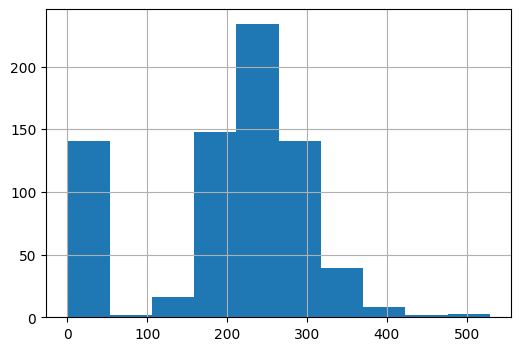

In [11]:
plt.rcParams["figure.figsize"] = (6,4)
train_df['Cholesterol'].hist()

### Fixing Cholesterol Distribution

In [12]:
chol_mean = train_df['Cholesterol'].replace(0, np.NaN).mean()
chol_std = train_df['Cholesterol'].replace(0, np.NaN).std()
train_df['Cholesterol'] = train_df['Cholesterol'].replace(0, chol_mean)
test_df['Cholesterol'] = test_df['Cholesterol'].replace(0, chol_mean)

### Normalizing

Only normalize Age, RestingBP, Cholesterol and MaxHR (and maybe Oldpeak)

In [13]:
names = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']
for name in names:
    if name == 'Cholesterol':
        test_df[name] = (test_df[name] - train_df[name].mean()) / chol_std
        train_df[name] = (train_df[name] - train_df[name].mean()) / chol_std
    else:
        test_df[name] = (test_df[name] - train_df[name].mean()) / train_df[name].std()
        train_df[name] = (train_df[name] - train_df[name].mean()) / train_df[name].std()

### Correlation Matrix

<Axes: >

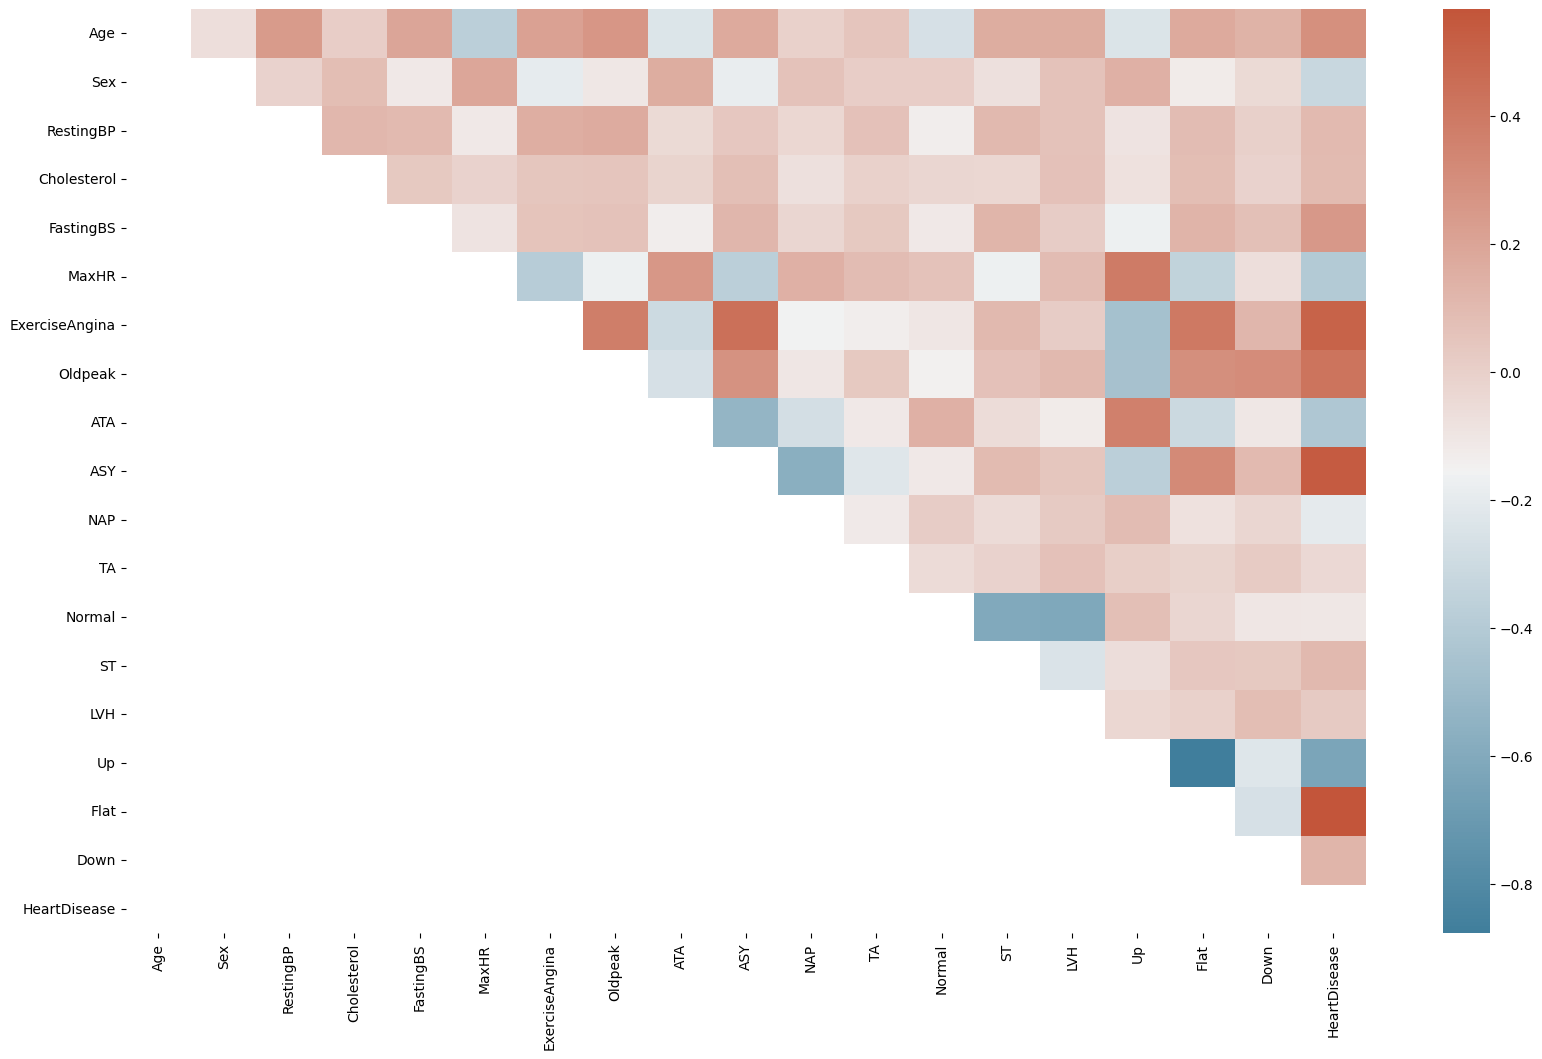

In [14]:
plt.rcParams["figure.figsize"] = (20,12)
mask = np.tril(np.ones_like(train_df.corr(), dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(train_df.corr(), mask=mask, cmap=cmap)

In [15]:
train_df = train_df.drop(columns=['HeartDisease'])

## Q2 Logistic Regression

#### What preprocessing step is crucial to ensure comparability of feature coefficients?

Normalizing as done in Q1 is crucial, as otherwise the feature values have magnitudes and therefore the feature coefficients will have different magnitudes as well.

### Fit Classifier

In [16]:
log_clf = LogisticRegression(penalty='l1', solver='liblinear').fit(train_df, y)

### Evaluate Metrics

In [17]:
y_pred = log_clf.predict(test_df)

In [18]:
f1_score(y_test, y_pred)

0.8533333333333333

In [19]:
balanced_accuracy_score(y_test, y_pred)

0.807985257985258

In [20]:
log_coef = np.abs(np.squeeze(log_clf.coef_))

### Plot absolute magnitude of feature coefficients

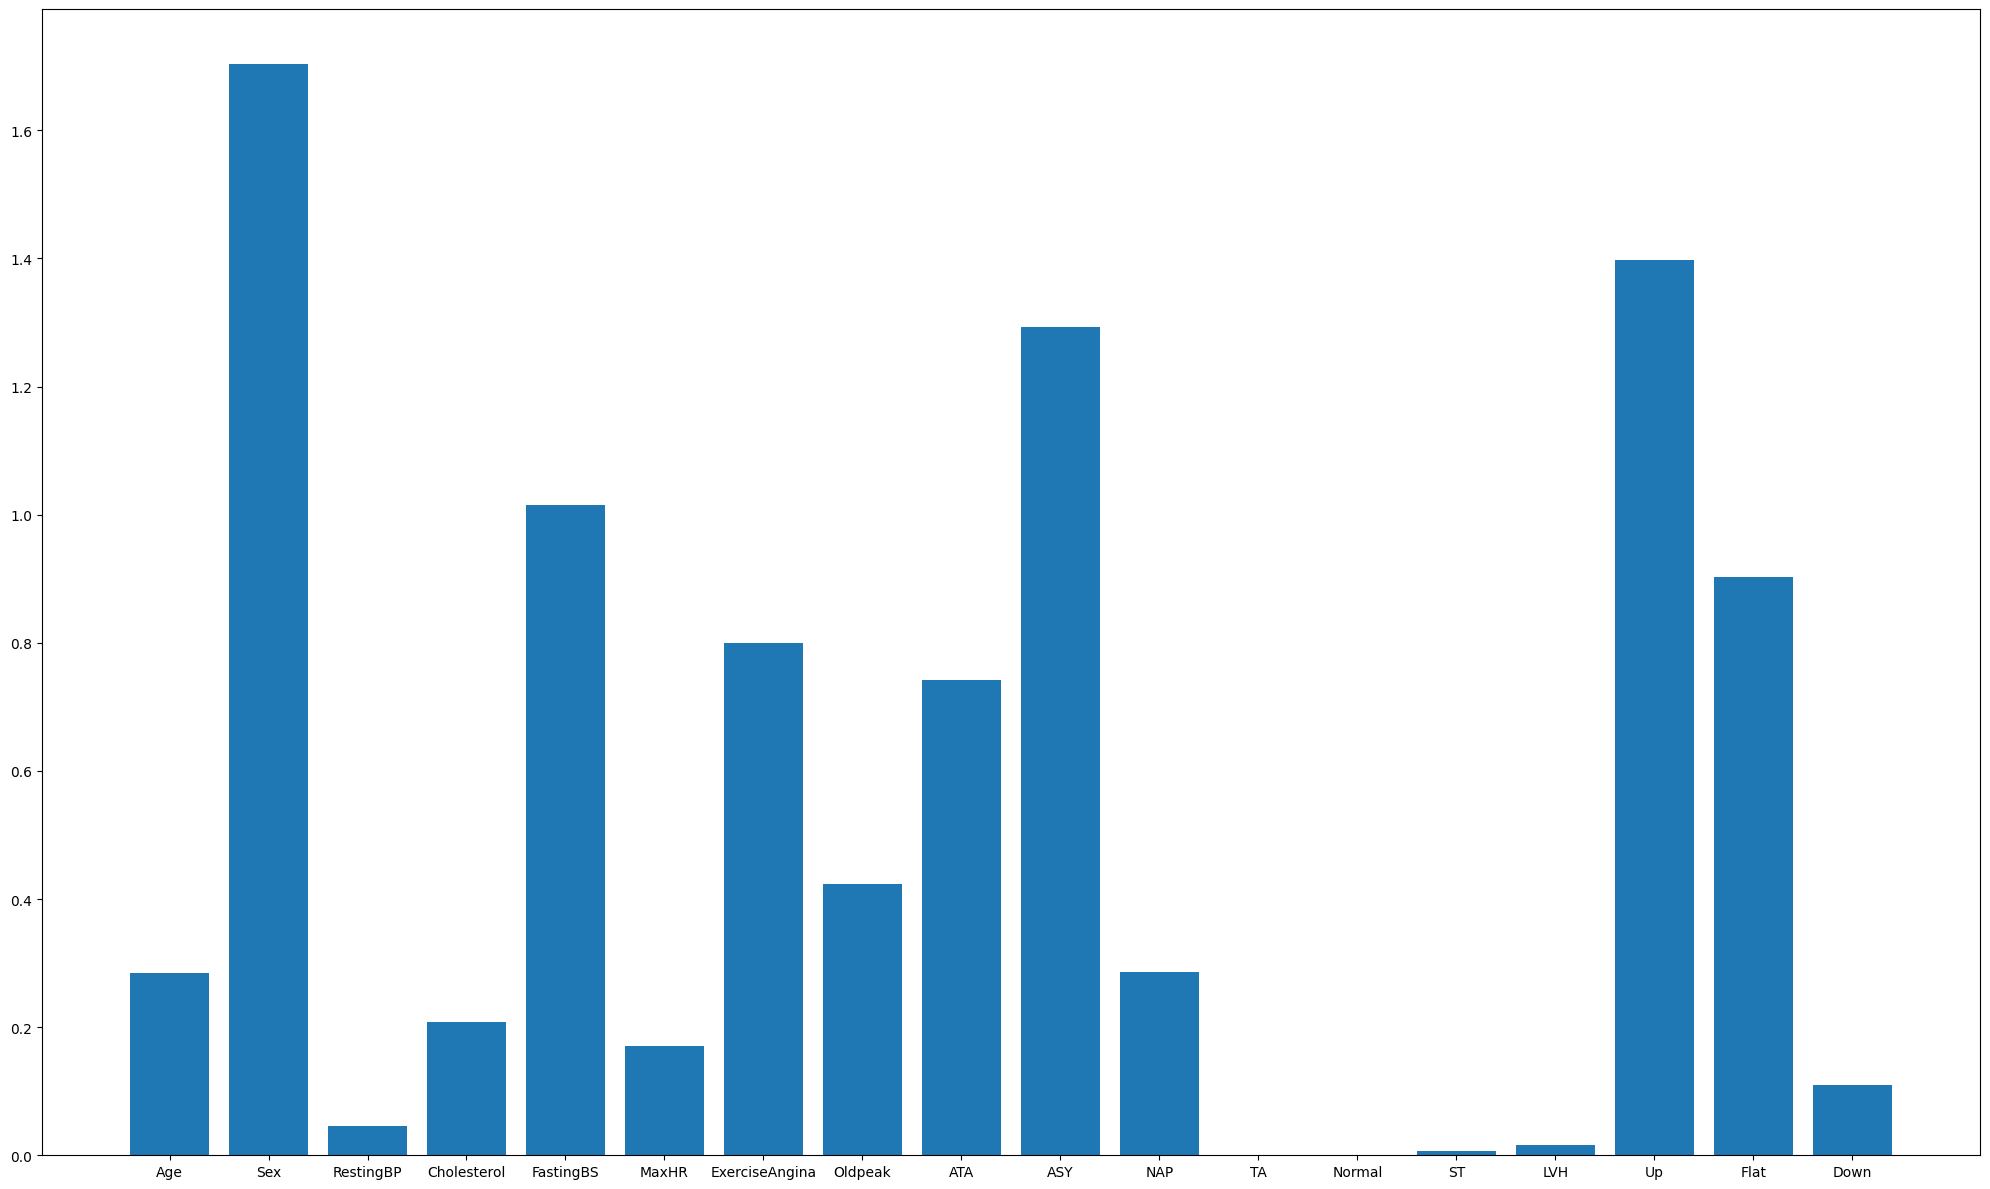

In [21]:
plt.rcParams["figure.figsize"] = (20,12)
plt.bar(train_df.columns, log_coef)
plt.tight_layout()

#### Finally, argue for or against fitting a logistic regression using only the important variables, as determined by the Lasso model, to arrive at the final coefficients instead of keeping the coefficients of the Lasso model.

The Lasso model only captures linear dependencies of the labels on the input features.
Discarded features with small coefficients could have strong interactions with other features, but those too go undetected.
Methods such as random forest importance are more suited for this task

## Q3 Decision Tree

### Fit Classifier

In [22]:
tree_clf = DecisionTreeClassifier().fit(train_df, y)

### Evaluate Metrics

In [23]:
y_pred = tree_clf.predict(test_df)

In [24]:
f1_score(y_test, y_pred)

0.7834101382488479

In [25]:
balanced_accuracy_score(y_test, y_pred)

0.7377149877149878

### Plot Gini Importances

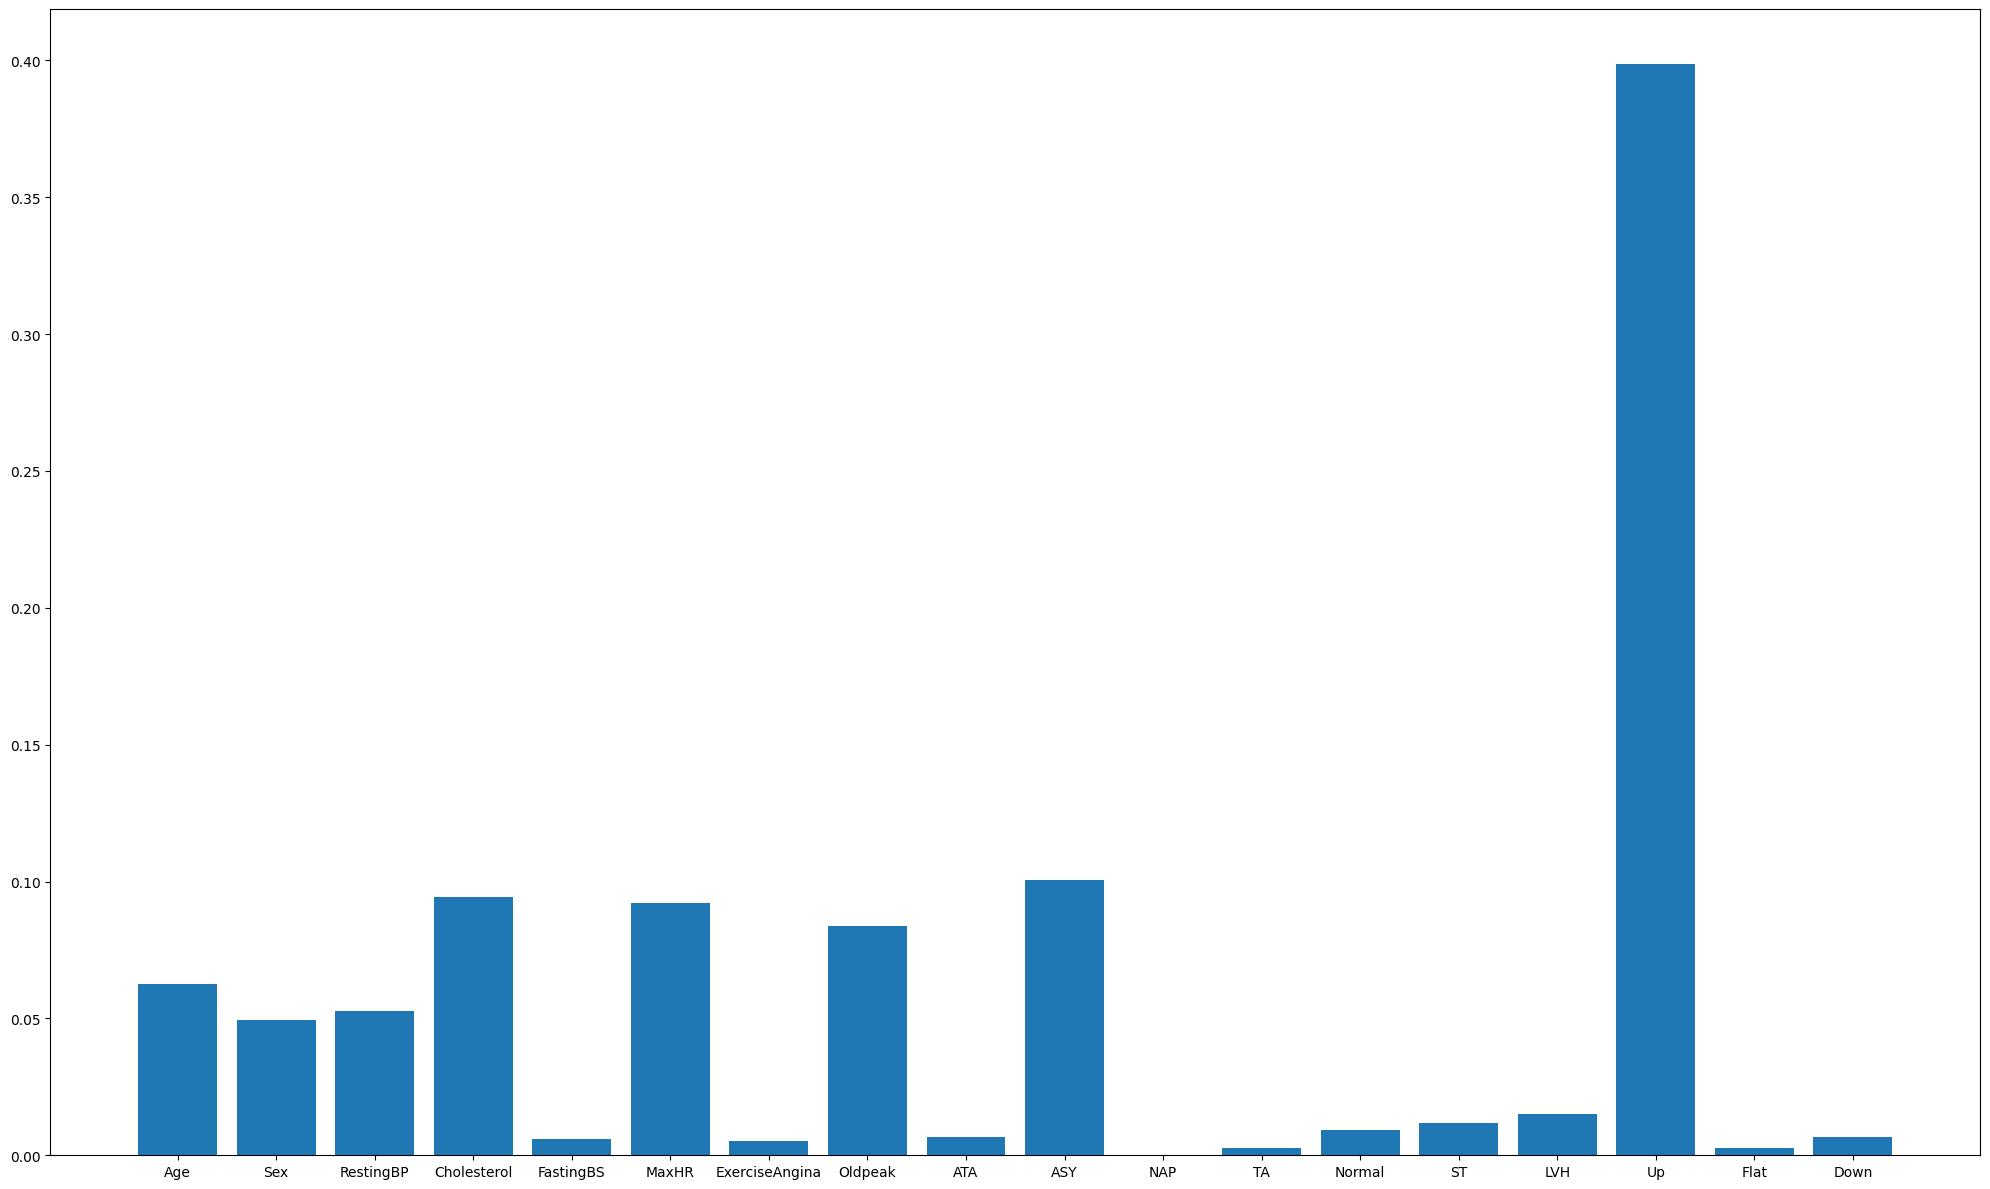

In [26]:
plt.rcParams["figure.figsize"] = (20,12)
plt.bar(train_df.columns, tree_clf.feature_importances_)
plt.tight_layout()

## Q4 Multi-Layer Perceptron

### Defining a 2 layer Neural Network

In [27]:
class MLP(nn.Module):
    
    def __init__(self, dim=18):
        
        super().__init__()
        
        self.layers = nn.Sequential(
            nn.Linear(dim, dim),
            nn.ReLU(),
            nn.Linear(dim, 1)
        )
        
    def forward(self, x):
        
        return self.layers(x)
    
class HeartDataset(Dataset):
    
    def __init__(self, features, labels):
        
        self.features = features
        self.labels = labels

    def __len__(self):
        return self.features.shape[0]

    def __getitem__(self, idx):
            
        return torch.tensor(self.features[idx], dtype=torch.float32), torch.tensor(self.labels[idx], dtype=torch.float32)

### Split into train and validation datasets
This is done to keep avoid overfitting when training the neural network

In [28]:
X_train, X_val, y_train, y_val = train_test_split(train_df, y, test_size=0.2, random_state=42)

### DataLoader

In [29]:
train_dataset = HeartDataset(X_train.values, y_train.values)
full_dataset = HeartDataset(train_df.values, y.values)
val_x = torch.tensor(X_val.values, dtype=torch.float32)
val_y = torch.tensor(y_val.values, dtype=torch.float32)

In [30]:
full_dataloader = DataLoader(full_dataset, batch_size=32, shuffle=True, num_workers=0)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)

### Loss Function

In [31]:
mlp = MLP()

In [32]:
loss_fn = nn.BCEWithLogitsLoss()

### Train-Val Loop for determining hyperparameters

In [33]:
def train_mlp(model, epochs, dataloader, val=True):
    
    optimizer = optim.Adam(model.parameters(),
                       lr=5e-3)
    
    for epoch in range(epochs):

        train_loss_cum = 0
        cum = 0

        for x,y in dataloader:

            optimizer.zero_grad()
            out = torch.squeeze(model(x))
            loss = loss_fn(out, y)
            loss.backward()
            optimizer.step()

            train_loss_cum += x.shape[0] * loss
            cum += x.shape[0]

        if val:
            
            with torch.no_grad():

                out = torch.squeeze(model(val_x))
                val_loss = loss_fn(out, val_y)

        train_loss = train_loss_cum/cum

        if epoch % 5 == 0:
            
            if val:
                
                print(f'Epoch {epoch} | '
                      f'Train loss: {train_loss:.4f} | '
                      f'Val loss: {val_loss:.4f}')
                
            else:
                
                print(f'Epoch {epoch} | '
                      f'Train loss: {train_loss:.4f}') 

In [34]:
train_mlp(mlp, epochs=31, dataloader=train_dataloader)

Epoch 0 | Train loss: 0.6164 | Val loss: 0.5229
Epoch 5 | Train loss: 0.3054 | Val loss: 0.2975
Epoch 10 | Train loss: 0.2868 | Val loss: 0.2965
Epoch 15 | Train loss: 0.2699 | Val loss: 0.2837
Epoch 20 | Train loss: 0.2560 | Val loss: 0.2830
Epoch 25 | Train loss: 0.2424 | Val loss: 0.2816
Epoch 30 | Train loss: 0.2303 | Val loss: 0.2862


### Train on full training dataset

In [35]:
mlp = MLP()

In [36]:
train_mlp(mlp, epochs=11, dataloader=full_dataloader, val=False)

Epoch 0 | Train loss: 0.5900
Epoch 5 | Train loss: 0.3059
Epoch 10 | Train loss: 0.2868


### Evaluate Metrics

In [37]:
test_x = torch.tensor(test_df.values, dtype=torch.float32)

In [38]:
with torch.no_grad():
    y_pred = torch.sigmoid(mlp(test_x)).numpy().squeeze()

In [39]:
y_pred = np.round(y_pred)

In [40]:
f1_score(y_test, y_pred)

0.868421052631579

In [41]:
balanced_accuracy_score(y_test, y_pred)

0.8216216216216217

### Shap values

In [42]:
train_x = torch.tensor(X_train.values, dtype=torch.float32)

In [43]:
explainer = shap.DeepExplainer(mlp, train_x)

In [44]:
positive = np.where(y_pred == 1)[0][:4]
negative = np.where(y_pred == 0)[0][:4]

In [45]:
positive_x = test_x[positive]
negative_x = test_x[negative]

In [46]:
positive_shap_values = explainer.shap_values(positive_x)
negative_shap_values = explainer.shap_values(negative_x)
overall_shap_values = explainer.shap_values(train_x)

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


### Shapley Plot for 4 positive samples

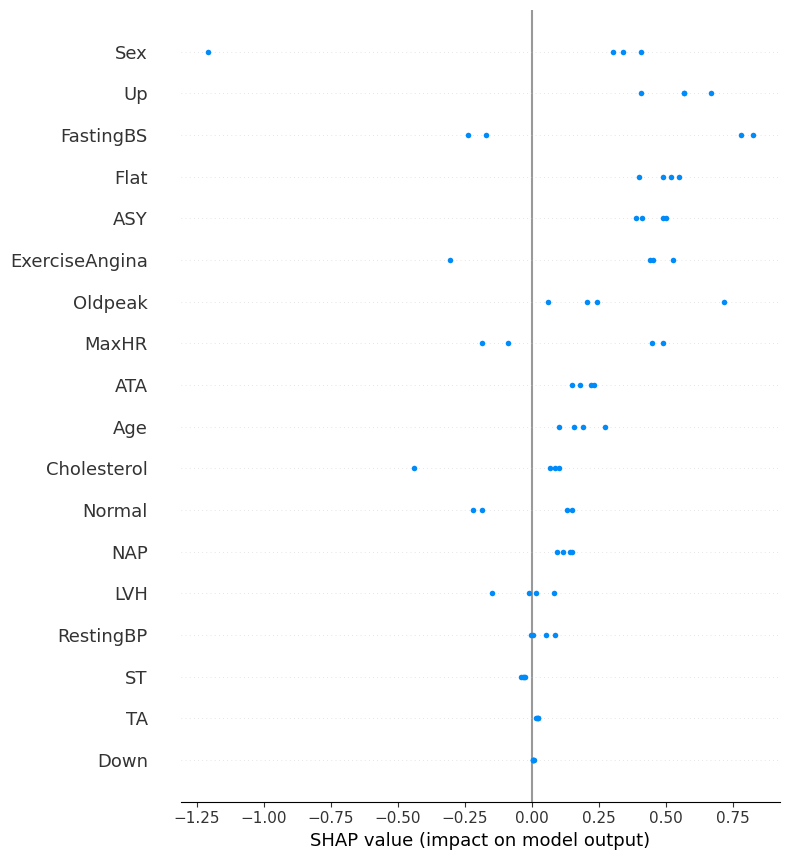

In [47]:
plt.rcParams["figure.figsize"] = (20,12)
shap.summary_plot(positive_shap_values, feature_names=X_train.columns)

### Shapley Plot for 4 negative values

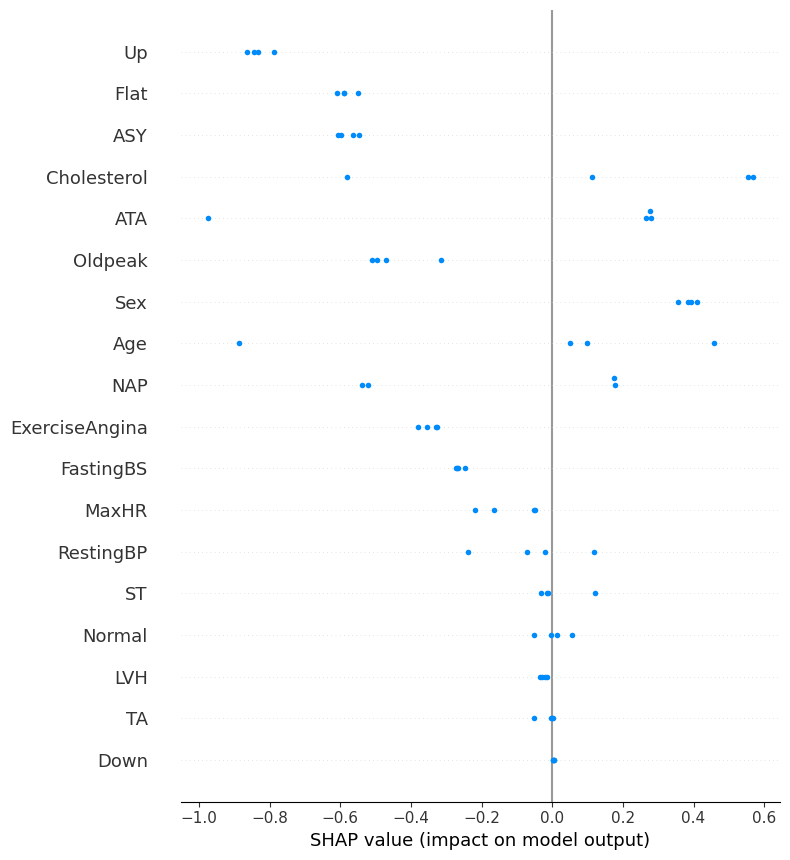

In [48]:
plt.rcParams["figure.figsize"] = (20,12)
shap.summary_plot(negative_shap_values, feature_names=X_train.columns)

### Shapley Plot for all train samples

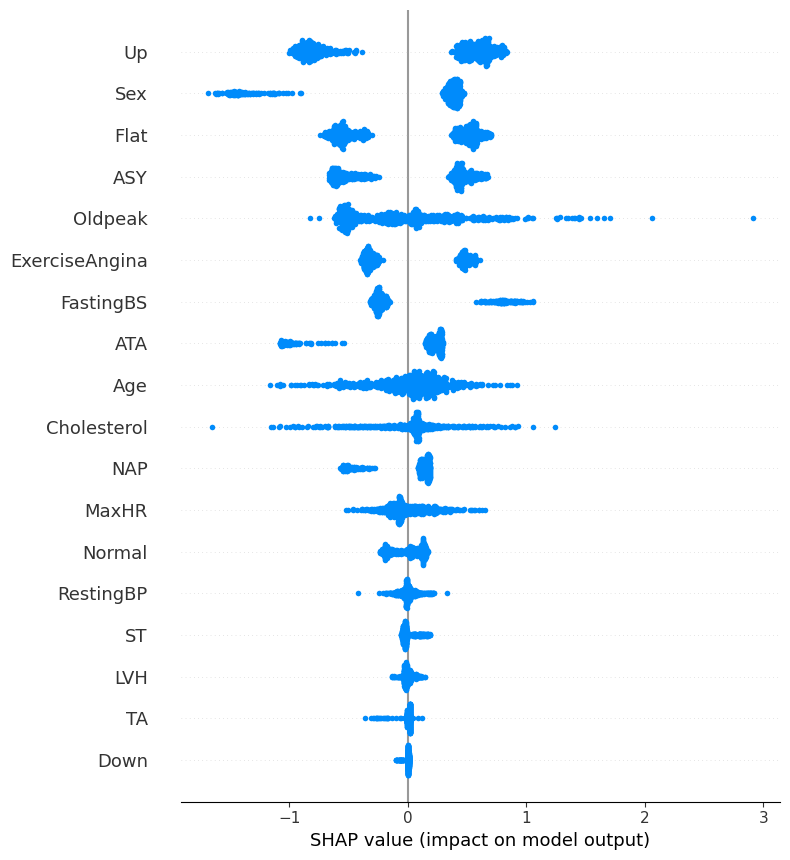

In [49]:
plt.rcParams["figure.figsize"] = (20,12)
shap.summary_plot(overall_shap_values, feature_names=X_train.columns)

### Are feature importances consistent across different predictions and compared to overall importance values? Elaborate on your findings!

The feature importances are mostly consistent, although there are some outliers.

## Challenge 1: Neural Additive Models 

In [50]:
class NAM(nn.Module):
    
    def __init__(self, dim=18):
        
        super().__init__()
        
        self.dnns = [
            self.dnn() for i in range(dim)
        ]
        
        self.dim = dim
        self.dropout = nn.Dropout(p=0.0)
        self.relu = nn.ReLU()
        self.last = nn.Linear(18, 1)
        
    def dnn(self):
        
        layers = [
            nn.Linear(1, 64),
            nn.Linear(64, 64),
            nn.Linear(64, 32),
            nn.Linear(32, 1)
        ]
        
        return layers
        
    def forward(self, x):
        
        out = torch.empty((x.shape[0], self.dim), dtype=torch.float32)
        for i in range(self.dim):
            a = torch.unsqueeze(x[:,i], dim=1)
            for layer in self.dnns[i]:
                a = layer(a)
                a = self.relu(a)
                a = self.dropout(a)
            out[:, i] = torch.squeeze(a)
            
        return self.last(self.dropout(out)), out

In [51]:
nam = NAM()

### Loss Function and Optimizer

In [52]:
def featureLoss(x):
    
    return torch.sum(x**2)

In [53]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(nam.parameters(),
                       lr=1e-1, weight_decay=1e-6)
output_penalty = 1e-3

In [54]:
epochs = 501

for epoch in range(epochs):
    
    train_loss_cum = 0
    cum = 0

    for x,y in train_dataloader:
    
        optimizer.zero_grad()
        out, features = nam(x)
        out = torch.squeeze(out)
        loss = loss_fn(out, y) + output_penalty * featureLoss(features)
        loss.backward()
        optimizer.step()
        
        train_loss_cum += x.shape[0] * loss
        cum += x.shape[0]
    
    with torch.no_grad():
        
        out, features = nam(val_x)
        out = torch.squeeze(out)
        val_loss = loss_fn(out, val_y)
    
    train_loss = train_loss_cum/cum
        
    if epoch % 20 == 0:
        
        print(f'Epoch {epoch} | '
              f'Train loss: {train_loss:.4f} | '
              f'Val loss: {val_loss:.4f}')

Epoch 0 | Train loss: 0.6904 | Val loss: 0.6630
Epoch 20 | Train loss: 0.4383 | Val loss: 0.4203
Epoch 40 | Train loss: 0.3950 | Val loss: 0.3760
Epoch 60 | Train loss: 0.3827 | Val loss: 0.3662
Epoch 80 | Train loss: 0.3800 | Val loss: 0.3612
Epoch 100 | Train loss: 0.3694 | Val loss: 0.3572
Epoch 120 | Train loss: 0.3654 | Val loss: 0.3523
Epoch 140 | Train loss: 0.3668 | Val loss: 0.3513
Epoch 160 | Train loss: 0.3634 | Val loss: 0.3510
Epoch 180 | Train loss: 0.3637 | Val loss: 0.3524
Epoch 200 | Train loss: 0.3649 | Val loss: 0.3504
Epoch 220 | Train loss: 0.3666 | Val loss: 0.3487
Epoch 240 | Train loss: 0.3622 | Val loss: 0.3502
Epoch 260 | Train loss: 0.3600 | Val loss: 0.3483
Epoch 280 | Train loss: 0.3596 | Val loss: 0.3482
Epoch 300 | Train loss: 0.3661 | Val loss: 0.3497
Epoch 320 | Train loss: 0.3584 | Val loss: 0.3475
Epoch 340 | Train loss: 0.3604 | Val loss: 0.3477
Epoch 360 | Train loss: 0.3603 | Val loss: 0.3476
Epoch 380 | Train loss: 0.3606 | Val loss: 0.3474
Epoch 

### Train on full dataset

In [63]:
nam = NAM()
optimizer = optim.Adam(nam.parameters(),
                       lr=1e-1, weight_decay=1e-6)
output_penalty = 1e-3

In [64]:
epochs = 501

for epoch in range(epochs):
    
    train_loss_cum = 0
    cum = 0

    for x,y in full_dataloader:
    
        optimizer.zero_grad()
        out, features = nam(x)
        out = torch.squeeze(out)
        loss = loss_fn(out, y) + output_penalty * featureLoss(features)
        loss.backward()
        optimizer.step()
        
        train_loss_cum += x.shape[0] * loss
        cum += x.shape[0]
    
    
    train_loss = train_loss_cum/cum
        
    if epoch % 20 == 0:
        
        print(f'Epoch {epoch} | '
              f'Train loss: {train_loss:.4f}')

Epoch 0 | Train loss: 0.6839
Epoch 20 | Train loss: 0.4438
Epoch 40 | Train loss: 0.4031
Epoch 60 | Train loss: 0.3836
Epoch 80 | Train loss: 0.3756
Epoch 100 | Train loss: 0.3706
Epoch 120 | Train loss: 0.3640
Epoch 140 | Train loss: 0.3618
Epoch 160 | Train loss: 0.3630
Epoch 180 | Train loss: 0.3640
Epoch 200 | Train loss: 0.3628
Epoch 220 | Train loss: 0.3557
Epoch 240 | Train loss: 0.3553
Epoch 260 | Train loss: 0.3546
Epoch 280 | Train loss: 0.3532
Epoch 300 | Train loss: 0.3604
Epoch 320 | Train loss: 0.3542
Epoch 340 | Train loss: 0.3533
Epoch 360 | Train loss: 0.3543
Epoch 380 | Train loss: 0.3504
Epoch 400 | Train loss: 0.3516
Epoch 420 | Train loss: 0.3502
Epoch 440 | Train loss: 0.3498
Epoch 460 | Train loss: 0.3486
Epoch 480 | Train loss: 0.3516
Epoch 500 | Train loss: 0.3500


In [65]:
with torch.no_grad():
    y_pred, features = nam(test_x)
    y_pred = torch.sigmoid(y_pred).numpy().squeeze()

In [66]:
y_pred = np.round(y_pred)

In [67]:
f1_score(y_test, y_pred)

0.8546255506607929

In [68]:
balanced_accuracy_score(y_test, y_pred)

0.8057739557739558